**Snake Species Identification**

In [1]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
SEED = 1000
IMG_SIZE = 50
BATCH_SIZE = 256

TRAIN_DIR = '../input/snake-dataset-india/Snake Images/train'
TEST_DIR = '../input/snake-dataset-india/Snake Images/test'

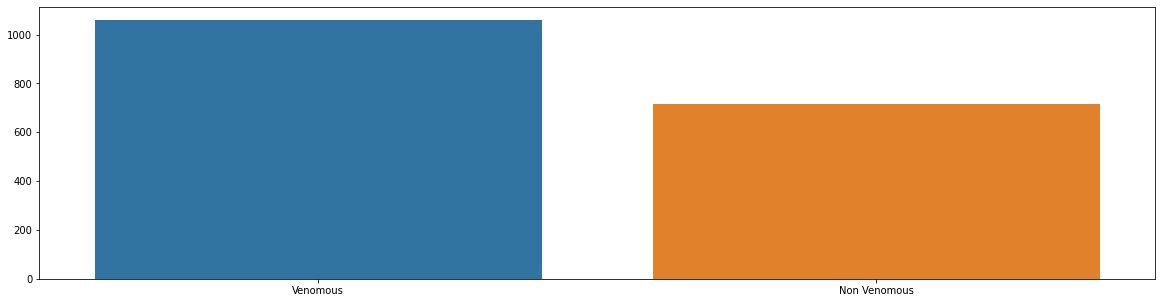

In [3]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

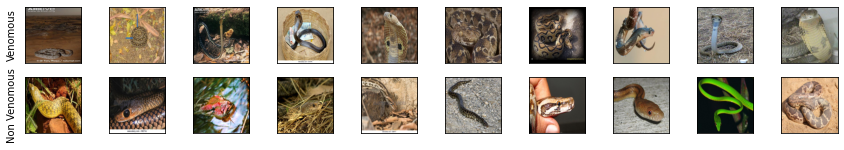

In [4]:
plt.figure(figsize=(12,5))
i=0
for c in os.listdir(TRAIN_DIR):
  path = os.path.join(TRAIN_DIR, c)
  for img in os.listdir(path):
        try:
            img_arr = cv2.cvtColor( cv2.imread(os.path.join(path, img)), cv2.COLOR_BGR2RGB)
            plt.subplot(5, 10, i+1)
            plt.imshow(img_arr)
            plt.xticks([])
            plt.yticks([])
            if i%10 == 0:
              plt.ylabel(c)
            i += 1
            if i%10 == 0:
              break
        except:
            pass
plt.tight_layout()
plt.show()

In [5]:
train_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.9,
    height_shift_range=0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    dtype=tf.float32
)

In [6]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'sparse',
    seed=SEED
)

Found 1775 images belonging to 2 classes.


In [7]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'sparse',
    seed=SEED
)

Found 1775 images belonging to 2 classes.


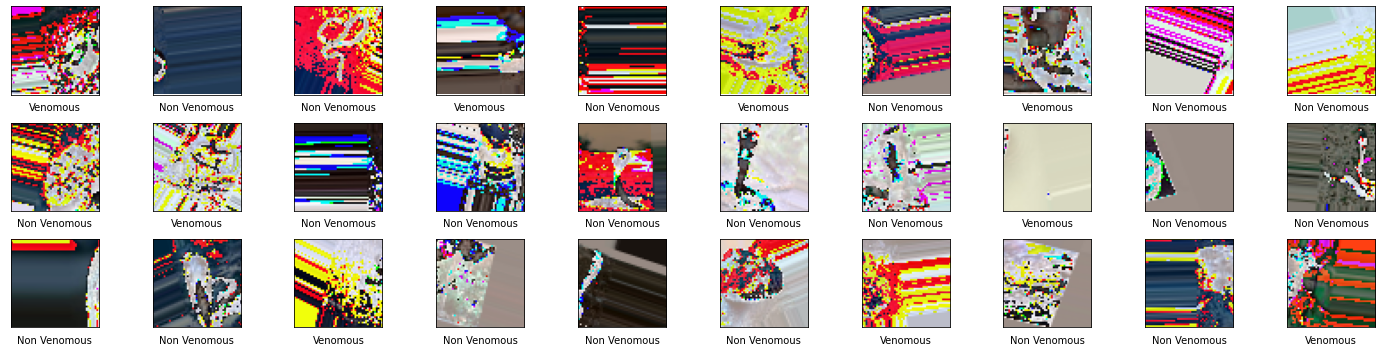

In [8]:
imgs, labels = next(train_batch)
i=0
plt.figure(figsize=(20,5))
for img,label in zip(imgs,labels):
  plt.subplot(3,10,i+1)
  plt.imshow(img.astype('uint8'))
  plt.xlabel(class_names[label.astype('int32')])
  plt.xticks([])
  plt.yticks([])
  i+=1
  if i==30:
    break
plt.tight_layout()
plt.show()

In [9]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

2022-11-28 11:46:23.123801: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94781440/94765736 [==============================] - 4s 0us/step


In [10]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [11]:
base_model.trainable = False

In [12]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026  

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [14]:
h = model.fit(train_batch, 
              epochs=50,
              steps_per_epoch = 1775 // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 1775 // BATCH_SIZE
             )

2022-11-28 11:46:31.097540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
6/6 [==============================] - 42s 7s/step - loss: 1.0879 - accuracy: 0.5300 - val_loss: 0.8941 - val_accuracy: 0.4987
Epoch 2/50
6/6 [==============================] - 32s 6s/step - loss: 0.9330 - accuracy: 0.5471 - val_loss: 0.8274 - val_accuracy: 0.6100
Epoch 3/50
6/6 [==============================] - 32s 6s/step - loss: 0.8972 - accuracy: 0.5820 - val_loss: 0.7868 - val_accuracy: 0.5443
Epoch 4/50
6/6 [==============================] - 32s 6s/step - loss: 0.7757 - accuracy: 0.5991 - val_loss: 0.7506 - val_accuracy: 0.6178
Epoch 5/50
6/6 [==============================] - 32s 6s/step - loss: 0.8009 - accuracy: 0.5996 - val_loss: 0.6935 - val_accuracy: 0.6211
Epoch 6/50
6/6 [==============================] - 32s 6s/step - loss: 0.8200 - accuracy: 0.5787 - val_loss: 0.6868 - val_accuracy: 0.6484
Epoch 7/50
6/6 [==============================] - 33s 6s/step - loss: 0.7668 - accuracy: 0.6090 - val_loss: 0.6620 - val_accuracy: 0.6341
Epoch 8/50
6/6 [==================

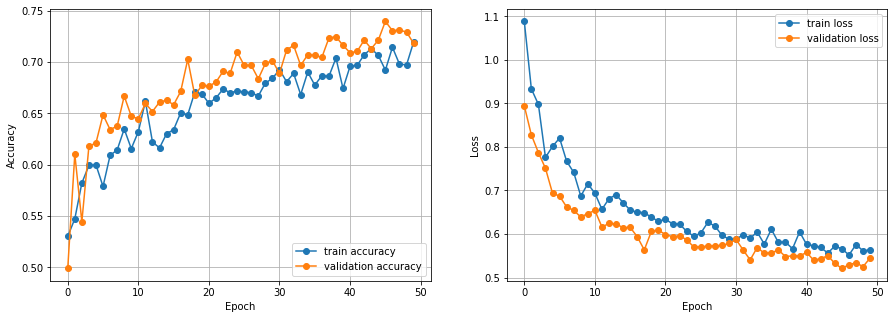

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [16]:
test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    dtype=tf.float32
)

In [17]:
test_batch = train_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'sparse',
    seed=SEED
)

Found 269 images belonging to 2 classes.


In [18]:
test_loss, test_acc = model.evaluate(test_batch)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

2/2 [==============================] - 3s 141ms/step - loss: 0.6940 - accuracy: 0.6245

Test Accuracy: 0.624535322189331

Test Loss: 0.69399094581604
